In [1]:
"""
Model Parameters :  
    GRAPH :
        directed
        node :
            node_id
            label
            probability
        edge :
            source
            target

    n -> population size
    k -> seed set size
    flight_length -> flight lengths of crows
    epoch -> max number of iterations
    awareness_probability-> awareness probability 
    alpha -> constant to calculate node_contribution_index. used for optimisation using random walk
    beta ->  constant to select candidates for random walk
"""


'\nModel Parameters :  \n    GRAPH :\n        directed\n        node :\n            node_id\n            label\n            probability\n        edge :\n            source\n            target\n\n    n -> population size\n    k -> seed set size\n    flight_length -> flight lengths of crows\n    epoch -> max number of iterations\n    awareness_probability-> awareness probability \n    alpha -> constant to calculate node_contribution_index. used for optimisation using random walk\n    beta ->  constant to select candidates for random walk\n'

In [2]:
import networkx as nx
import random 
import itertools
import pandas as pd
import matplotlib as plt

[(0, {'label': 'Beak', 'probability': 0.01}), (1, {'label': 'Beescratch', 'probability': 0.01}), (2, {'label': 'Bumper', 'probability': 0.01}), (3, {'label': 'CCL', 'probability': 0.01}), (4, {'label': 'Cross', 'probability': 0.01}), (5, {'label': 'DN16', 'probability': 0.01}), (6, {'label': 'DN21', 'probability': 0.01}), (7, {'label': 'DN63', 'probability': 0.01}), (8, {'label': 'Double', 'probability': 0.01}), (9, {'label': 'Feather', 'probability': 0.01}), (10, {'label': 'Fish', 'probability': 0.01}), (11, {'label': 'Five', 'probability': 0.01}), (12, {'label': 'Fork', 'probability': 0.01}), (13, {'label': 'Gallatin', 'probability': 0.01}), (14, {'label': 'Grin', 'probability': 0.01}), (15, {'label': 'Haecksel', 'probability': 0.01}), (16, {'label': 'Hook', 'probability': 0.01}), (17, {'label': 'Jet', 'probability': 0.01}), (18, {'label': 'Jonah', 'probability': 0.01}), (19, {'label': 'Knit', 'probability': 0.01}), (20, {'label': 'Kringel', 'probability': 0.01}), (21, {'label': 'MN1

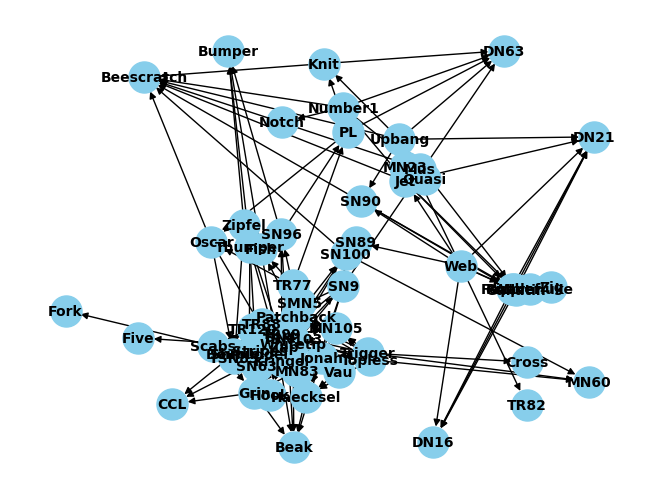

In [3]:

#build graph from data
G = nx.read_gml("../tests/test2.gml", label = 'id')
for node in G.nodes:
    G.nodes[node]['probability'] = 0.01

#visualizing the graph
print(G.nodes(data=True))
print(G.edges(data=True))

# Define node positions (optional)
pos = nx.spring_layout(G)
# Get node labels
node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
# Draw the graph
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')


In [4]:
print(G.out_degree())

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 1), (9, 2), (10, 2), (11, 0), (12, 0), (13, 3), (14, 2), (15, 1), (16, 1), (17, 4), (18, 1), (19, 2), (20, 3), (21, 1), (22, 1), (23, 0), (24, 3), (25, 1), (26, 2), (27, 5), (28, 3), (29, 4), (30, 3), (31, 1), (32, 2), (33, 4), (34, 2), (35, 1), (36, 3), (37, 7), (38, 4), (39, 1), (40, 7), (41, 3), (42, 4), (43, 5), (44, 4), (45, 8), (46, 1), (47, 6), (48, 0), (49, 2), (50, 6), (51, 9), (52, 4), (53, 1), (54, 6), (55, 2), (56, 2), (57, 9), (58, 1), (59, 5), (60, 1), (61, 3)]


In [5]:
#replace for diversity in crow nodes
def replace(j,seed,left):
    index = random.randint(0,len(left) - 1)
    seed[j], left[index] = left[index], seed[j]
    return seed[j]


# returns a list of crow positions 
def initialize_population(G, n, k) :
    nodes_degree = list(G.out_degree())
    nodes_degree = [x[0] for x in sorted(nodes_degree, key=lambda x: x[1])]

    population = []
    for i in range(n) :
        seed, left = nodes_degree[:k], nodes_degree[k:]
        for j in range(k):
            if(random.random() > 0.5):                                                          # REPLACEMENT PARAMETER = 0.5 
                seed[j] = replace(j,seed,left)
        population.append(seed)
    return population


In [6]:
initialize_population(G, 1, 5)

[[0, 1, 55, 3, 4]]

In [7]:
#initialize a vector r_val[n] where 0<r[i]<1
def initialize_random(n):
    r_val = [random.random() for i in range(n)]
    return r_val

In [8]:
initialize_random(3)

[0.5090022527776447, 0.6790294097718206, 0.14354093642076438]

In [9]:
def local_influence_estimate(G : nx.classes.digraph.DiGraph, seed : list) :
    k = len(seed)
    seed_set = set(seed)


    one_neighbours = set()
    for node_id in seed_set :
        one_neighbours.update(set(G.neighbors(node_id)))
    one_neighbours = one_neighbours - seed_set

    
    two_neighbours = set()
    for node_id1 in one_neighbours :
        two_neighbours.update(set(G.neighbors(node_id1)))
    two_neighbours = two_neighbours - seed_set

    one_hop_area = len(one_neighbours)
    if one_hop_area == 0:
        return k
    two_hop_area = len(two_neighbours)

    sigma_0 = k
    sigma_1 = 0
    for node_id1 in one_neighbours:
        val = 1
        for node_id in seed_set:
            if(G.has_edge(node_id1,node_id)) :
                p = G.nodes[node_id]['probability']
                val = val * ( 1 - p)
        sigma_1 += (1 - val)

    factor = 0

    
    for node_id2 in two_neighbours:
        p = G.nodes[node_id2]['probability']
        d = 0
        for node_id1 in one_neighbours:
            if(G.has_edge(node_id2, node_id1)):
                d += 1
        factor += p*d 
       
    factor /= one_hop_area
    factor += 1

    LIE = sigma_0 + factor * sigma_1
    return LIE

In [10]:
local_influence_estimate(G, [1,20,30,5,16])

5.0299

In [11]:
def get_updated_seed(seed, r, flight_length, memory):
    k = len(seed)

    intersection = set(seed).intersection(set(memory))
    seed_intersection_memory = [0 if node_id in intersection else 1 for node_id in seed]
    H_arg = [r * flight_length * sim for sim in seed_intersection_memory]
    H_val = [0 if H_arg_j < 1 else 1 for H_arg_j in H_arg]

    left = list(set(G.nodes()) - set(seed))
    seed = [seed[j] if H_val[j] == 0 else replace(j,seed,left) for j in range(k)]
    return seed;    

In [12]:
#TEST
get_updated_seed([1,20,30,5,16], 3, 2, [29,15,32,2,20] )

[17, 20, 14, 43, 23]

In [13]:
def get_seed_random_walk(candidates : list, k : int):
    assert len(candidates) >= k, "b>1 must be"
    temp = [x for x in  candidates]
    seed = []
    while len(seed) < k :
        node_id = random.choice(temp)
        seed.append(node_id)
        temp.remove(node_id)
    return seed

In [14]:
# TEST
get_seed_random_walk([5,6,7,2,15,16,54,62,51,1],3)

[16, 5, 1]

In [15]:
def get_best_seed(G, population : list) :
    best_seed = population[0]
    best_lie = local_influence_estimate(G, best_seed)
    for seed in population:
        if(local_influence_estimate(G, seed) > best_lie) :
            best_seed = seed
    return best_seed

In [16]:
get_best_seed(G, [[22,13,16], [1,20,13]])

[22, 13, 16]

In [17]:
import math
def generate_candidates_for_random_walk(G : nx.classes.digraph.DiGraph, alpha : float , beta : float, k : int) :
    #get k-shell values of all nodes
    k_shell = nx.core_number(G)
    #get structural hole values of all nodes  
    structural_hole = nx.effective_size(G)
    structural_hole = nx.betweenness_centrality(G)

    for node_id, sh_val in structural_hole.items():                                                     #ALTERATION
        if  math.isnan(sh_val) or sh_val == 0:  
            structural_hole[node_id] = 1

    #calculating node_contribution_index
    contribution_index =  {}
    k_shell_sum = sum(k_shell)
    structural_hole_inv_sum = 0
    for sh_val in structural_hole.values() :
        structural_hole_inv_sum += 1 / sh_val

    for node_id in G.nodes():
        contri_val = (alpha * k_shell[node_id] / k_shell_sum)
        contri_val += ((1 - alpha) * (1 / structural_hole[node_id]) / structural_hole_inv_sum)
        contribution_index[node_id] = contri_val
    
    #generating candidates
    candidates_count = beta * k
    contribution_index = dict(sorted(contribution_index.items(),key=lambda x:x[1],reverse=True))

    candidates = list(contribution_index.keys())
    candidates = candidates[:candidates_count]
    
    return candidates



In [18]:
#TESTING
generate_candidates_for_random_walk(G, 0.5, 2, 3)

[41, 19, 54, 32, 25, 53]

In [19]:
def local_search(G : nx.classes.digraph.DiGraph, best_seed : list) :
    k = len(best_seed)
    degree = {}
    for node_id in best_seed:
        degree[node_id] = G.out_degree(node_id)
    
    degree = dict(sorted(degree.items(), key=lambda x : x[1]))
    best_seed = list(degree.keys())

    for j in range(k):
        neighbours = list(set(G.neighbors(best_seed[j]))  - set(best_seed))

        new_best_seed = best_seed
        new_best_lie = local_influence_estimate(G, new_best_seed)

        for node_id_index in range(len(neighbours)):
            new_best_seed[j], neighbours[node_id_index] = neighbours[node_id_index], new_best_seed[j]
            if(local_influence_estimate(G, new_best_seed) > new_best_lie) :
                new_best_lie = local_influence_estimate(G,new_best_seed)
            else :
                new_best_seed[j], neighbours[node_id_index] = neighbours[node_id_index], new_best_seed[j]
        best_seed = new_best_seed

    return best_seed

In [20]:
local_search(G, [28,30,33])

[1, 30, 21]

In [21]:
lies = []
iters = []

In [22]:

def DCSA(G : nx.classes.digraph.DiGraph, n : int, k : int, epoch : int, flight_length : int , awareness_probability : int ,alpha : float, beta : float):
    """
    Implementation of CROW algorithm for influence maximization in social networks
    
    Args:
    - G: NetworkX directed graph object representing the social network
    - n: crow population size
    - k: number of nodes to select
    - epoch: maximum number of iterations
    - flight_length: length of flight of crows
    - awareness_probability: if crow j is aware of i following him
    
    Returns:
    - nodes: list of k nodes with the highest influence scores
    """

    # Initialize variables
    V = len(G.nodes())      #total number of nodes

    population = initialize_population(G,n,k)         # == x
    memory = initialize_population(G,n,k)     # == m
    r_val = initialize_random(V)        # == r

    best_seed = get_best_seed(G, population)
    candidates_for_random_walk = generate_candidates_for_random_walk(G, alpha, beta, k)

    for _ in range(epoch) :
                
        iters.append(_)
        lies.append(local_influence_estimate(G, best_seed))

        for i in range(n):
            f = i
            while(i == f) :
                f = random.randint(0,n-1)
                    
            # crow i follows crow f
            if r_val[f] > awareness_probability :
                population[i] = get_updated_seed(population[i], r_val[i], flight_length, memory[f])
            else :
                new_seed = get_seed_random_walk(candidates_for_random_walk, k)
                if (local_influence_estimate(G, new_seed) > local_influence_estimate(G, population[i])) :
                    population[i] = new_seed
        
        # update memory of crows
        for i in range(n):
            if local_influence_estimate(G, population[i]) > local_influence_estimate(G, memory[i]) :
                memory[i] = population[i]

        #update best seed
        best_seed = get_best_seed(G, population)
        
        #update best seed by local search
        new_best_seed = local_search(G, best_seed)
        if(local_influence_estimate(G, new_best_seed) > local_influence_estimate(G, best_seed)) :
            best_seed = new_best_seed

    return best_seed, local_influence_estimate(G, best_seed)


In [23]:
n = 30
k = 5
epoch = 100
flight_length = 2
awareness_probability = 0.1
alpha = 0.5
beta = 3
iters = []
lies = []
DCSA(
    G=G, 
    n=n, 
    k=k, 
    epoch=epoch, 
    flight_length=flight_length,
    awareness_probability=awareness_probability, 
    alpha= alpha, 
    beta = beta
    )

([21, 32, 5, 6, 40], 5.0602186)

In [24]:
print(len(iters))
print(len(lies))

100
100


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


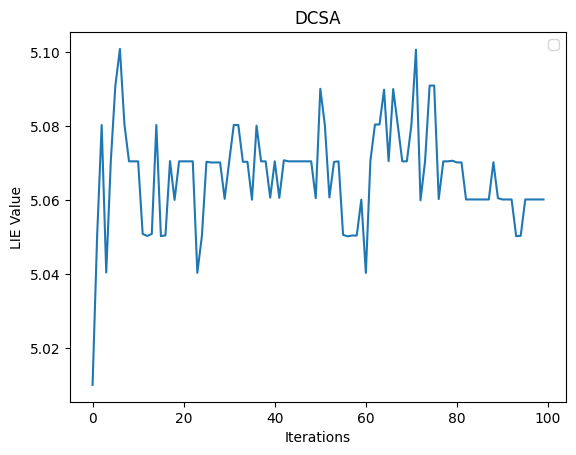

In [32]:
plt.pyplot.plot(iters,lies)
plt.pyplot.xlabel('Iterations')
plt.pyplot.ylabel('LIE Value')
plt.pyplot.title('DCSA')
plt.pyplot.legend()
# function to show the plot
plt.pyplot.show()

In [29]:
import networkx as nx
import random

def independent_cascade_model(G, seed_nodes, p):
    influenced_nodes = set(seed_nodes)
    active_nodes = set(seed_nodes)

    while active_nodes:
        new_active_nodes = set()
        for node in active_nodes:
            neighbors = set(G.neighbors(node)) - influenced_nodes
            for neighbor in neighbors:
                if random.random() < p:
                    new_active_nodes.add(neighbor)
                    influenced_nodes.add(neighbor)

        active_nodes = new_active_nodes

    return influenced_nodes

# Example usage
seed_nodes = [21, 32, 5, 6, 40]  # Replace with your seed node selection
p = 0.01  # Replace with your influence probability

num_simulations = 10000
results = []

for _ in range(num_simulations):
    influenced_nodes = independent_cascade_model(G, seed_nodes, p)
    results.append(len(influenced_nodes))

average_influence = sum(results) / num_simulations

print(f"Average Influence: {average_influence}")


Average Influence: 5.1019
